# Lab 6

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import math
import copy

# sieć

In [80]:
class MLP:

    def __init__(self, layers, weights, biases, activation_function='sigmoid', output_function='softmax'):
        self.layers = layers
        self.weights = weights
        self.biases = biases

        self.d_w = []
        self.d_b = []
        
        if activation_function == 'sigmoid':
            self.activation_function = self.sigmoid
            self.activation_derivative = self.sigmoid_derivative
            
        elif activation_function == 'tanh':
            self.activation_function = self.tanh
            self.activation_derivative = self.tanh_derivative
            
        elif activation_function == 'ReLU':
            self.activation_function = self.ReLU
            self.activation_derivative = self.ReLU_derivative
            
        else:
            self.activation_function = self.linear
            self.activation_derivative = self.linear_derivative

        if output_function == 'softmax':
            self.output_function = self.softmax
        else:
            self.output_function = self.linear

    def forward_prop(self, inputs):
        """
        performs forward propagation
        """
        # activations and linear combinations passed to activation function
        self.a = []
        self.z = []

        activations = inputs
        self.a.append(activations)
        # propagate all but last layer with activaton function
        for i in range(len(self.layers) - 2):
            outputs = activations.dot(self.weights[i]) + self.biases[i]
            self.z.append(outputs)
            activations = self.activation_function(outputs)
            self.a.append(activations)

        # propagate last layer with output function
        results = activations.dot(self.weights[-1]) + self.biases[-1]
        self.z.append(results)
        activations = self.output_function(results)
        self.a.append(activations)
        return activations

    def backpropagation(self, y):
        """
        packpropagates error using activation functions derivatives
        """
        deltas = [None] * len(self.weights)

        # last delta
        if self.output_function == self.softmax:
            last_delta = []
            for val_a, val_y in zip(self.a[-1], y):
                err = val_y - val_a
                a = val_a.reshape(val_a.shape[0],)
                di_dj = - a * a.reshape(self.layers[-1], 1)
                d_d = np.diag(a) + di_dj
                last_delta.append(d_d.dot(err))
            last_delta = np.array(last_delta)
            deltas[-1] = copy.deepcopy(last_delta)
            
        elif self.output_function == self.linear:
            deltas[-1] = y - self.a[-1]

        # previous deltas
        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = ((self.weights[i + 1].dot(deltas[i + 1].T)) * self.activation_derivative(self.z[i]).T).T

        # calculate derivatives
        d_b = [None] * len(deltas)
        d_w = [None] * len(deltas)
        for i, d in enumerate(deltas):
            d_w[i] = (d.T.dot(self.a[i])).T / y.shape[0]
            d_b[i] = (d.T.dot(np.ones((y.shape[0], 1)))).T / y.shape[0]

        return d_w, d_b
                    
    
    def train(self, x, y, epochs, lr, batch_size=1000, validation = None, regularization = 0):
        """
        trains neural network
        validation for early stop must be given as [X_validation, Y_validation]
        regularization: L2
        """
        # encode target for classification
        if self.output_function == self.softmax:
            encode = np.zeros((y.size, y.max() + 1))
            encode[np.arange(y.size), y.flatten()] = 1
            y = encode

        # randmize observations' order
        p = np.random.permutation(len(y))
        x = x[p]
        y = y[p]
        
        if validation:
            current_error = math.inf
        validation_decreases = 0
        
        for epoch in range(epochs):
            i = 0 
            # handle all batches
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                self.forward_prop(x_batch)
                
                # backpropagate
                d_w, d_b = self.backpropagation(y_batch)

                # gradient descent
                self.weights = [w*(1-regularization/batch_size) + lr*dweight for w, dweight in zip(self.weights, d_w)]
                self.bias = [b*(1-regularization/batch_size) + lr*dbias for b, dbias in zip(self.biases, d_b)]

            # print error
            if self.output_function == self.softmax:
                if epoch % 500 == 0 or epoch == epochs-1:
                    print("Epoch: {: <5} Cross entropy loss: {}".
                          format(epoch, metrics.log_loss(np.argmax(y_batch, axis=1), self.a[-1])))
            else:
                if epoch % 500 == 0 or epoch == epochs-1:
                    print("Epoch: {: <5} Mean absolute error: {}".format(epoch,np.abs(y_batch - self.a[-1]).mean()))
                    
                     
            if validation:
                previous_error = current_error
                validation_result = self.forward_prop(validation[0])
                current_error = np.abs(validation[1] - self.a[-1]).mean()
                if current_error < previous_error:
                    validation_decreases = 0 
                    # validation_decreases = np.max([0, validation_decreases-1])
                    # print(validation_decreases)
                if current_error > previous_error:
                    validation_decreases += 1
                    # print(validation_decreases)
                    if validation_decreases > 100 and epoch > 1000:
                        print("Validation error has risen from {} to {}".format(previous_error, current_error))
                        print("Overfitting detected, stopping after epoch {}".format(epoch))
                        print(validation_decreases)
                        return
            
                
    @staticmethod
    def softmax(x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T

    @staticmethod
    def linear(x): 
        return(x)
    
    @staticmethod
    def linear_derivative(x): 
        return np.ones(x.shape[0]*x.shape[1]).reshape(x.shape[0], x.shape[1])
    
    @staticmethod
    def sigmoid(x):
        return np.exp(x) / (1 + np.exp(x))

    @staticmethod
    def sigmoid_derivative(x):
        def sigmoid(x):
            return np.exp(x) / (1 + np.exp(x))
        return sigmoid(x) * (1 - sigmoid(x))
    
    @staticmethod
    def tanh(x): 
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x): 
        return 1 - np.tanh(x)**2
    
    @staticmethod
    def ReLU(x):
        return x * (x > 0)

    @staticmethod
    def ReLU_derivative(x):
        return 1. * (x > 0)

    def show_attributes(self):
        """
        gives basic information about the neural network
        """
        print("Neural Network attributes:")
        print("-------------------------")
        print("Number of neurons in layers: {}".format(self.layers))
        print("Activation function used: {}".format(self.activation_function))
        print("Output activation function used: {}".format(self.output_function))
        return



def generate_random_mlp(layers, activation_function ='sigmoid', output_function='softmax', start=-1, stop=1):
    """
    generates mlp with random weights given number of neurons in each layer and activation functions
    """
    weights = []
    biases = []

    for i in range(len(layers) - 1):
        weights.append(np.random.uniform(start, stop, layers[i] * layers[i + 1]).reshape(layers[i], layers[i + 1]))
        biases.append(np.random.uniform(start, stop, layers[i + 1]).reshape(1, layers[i+1]))
    mlp = MLP(layers, weights, biases, activation_function=activation_function, output_function=output_function)
    return mlp

## multimodal-sparse

In [24]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/multimodal-sparse-training.csv',index_col=0)
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/regression/multimodal-sparse-test.csv',index_col=0)
x_train = np.asarray([train_df.iloc[:,0]]).T
y_train = np.asarray([train_df.iloc[:,1]]).T
x_test = np.asarray([test_df.iloc[:,0]]).T
y_test = np.asarray([test_df.iloc[:,1]]).T
train_df

,x,y
1,0.640965,80
2,1.863815,160
3,0.319832,0
4,0.760805,80
5,-0.151905,0
6,0.108743,0
7,1.225000,80
8,0.887118,80
9,-0.796100,-80
10,0.290411,0


Text(0.5, 1.0, 'Train split')

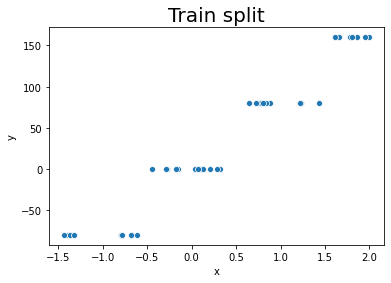

In [25]:
sns.scatterplot(x='x', y='y', data=train_df)
plt.title('Train split', fontsize=20)

In [34]:
validation = [x_test[0:100,:], y_test[0:100,:]]

Epoch: 0     Mean absolute error: 70.95312392049043
Epoch: 500   Mean absolute error: 12.91806667841801
Epoch: 1000  Mean absolute error: 7.27887584728983
Epoch: 1500  Mean absolute error: 9.381783859624289
Epoch: 2000  Mean absolute error: 9.450902522526722
Epoch: 2500  Mean absolute error: 9.116352328081188
Epoch: 3000  Mean absolute error: 3.8776927234538463
Epoch: 3500  Mean absolute error: 3.5055795919657102
Epoch: 4000  Mean absolute error: 1.8344428038023743
Epoch: 4500  Mean absolute error: 1.3313689063753487
Epoch: 5000  Mean absolute error: 1.0437035019204077
Epoch: 5500  Mean absolute error: 0.8478089891197698
Epoch: 6000  Mean absolute error: 0.7147136483395169
Epoch: 6500  Mean absolute error: 0.6302040908770494
Epoch: 7000  Mean absolute error: 0.5574161236703058
Epoch: 7500  Mean absolute error: 0.5486599390764237
Epoch: 8000  Mean absolute error: 0.543048534134508
Epoch: 8500  Mean absolute error: 0.517840540900897
Epoch: 9000  Mean absolute error: 0.4926701314681631
Ep

Text(0.5, 1.0, 'Test performance - sigmoid')

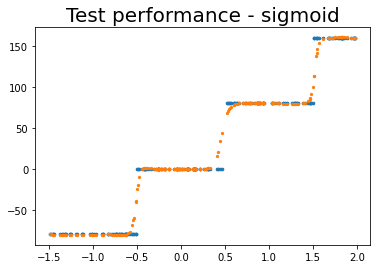

In [36]:
default_network = generate_random_mlp([1,10,30,10,1], activation_function="tanh", output_function='linear')
default_network.train(x_train, y_train, batch_size=128, epochs=10000, lr=0.001)

result = default_network.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=7)
plt.scatter(x=x_test, y=np.concatenate(result), s=5)
plt.title('Test performance - sigmoid', fontsize=20)

In [79]:
early_stop_network = generate_random_mlp([1,10,30,10,1], activation_function="tanh", output_function='linear')
early_stop_network.train(x_train, y_train, batch_size=128, epochs=150000, lr=0.001, validation=validation)



Epoch: 0     Mean absolute error: 69.71152352449779
Epoch: 500   Mean absolute error: 11.875648733340153
Epoch: 1000  Mean absolute error: 6.715444942451114
Epoch: 1500  Mean absolute error: 9.461556626069717
Epoch: 2000  Mean absolute error: 9.178744674072679
Epoch: 2500  Mean absolute error: 4.691473791154326
Epoch: 3000  Mean absolute error: 2.59960819730356
Epoch: 3500  Mean absolute error: 1.4054542168478625
Epoch: 4000  Mean absolute error: 0.8512314295684271
Epoch: 4500  Mean absolute error: 0.6944420538322646
Epoch: 5000  Mean absolute error: 0.581247818715313
Epoch: 5500  Mean absolute error: 0.5563808248928866
Epoch: 6000  Mean absolute error: 0.5194350596135389
Epoch: 6500  Mean absolute error: 0.4745048474266967
Epoch: 7000  Mean absolute error: 0.42951076302129876
Epoch: 7500  Mean absolute error: 0.388213900297308
Epoch: 8000  Mean absolute error: 0.35435348823744495
Epoch: 8500  Mean absolute error: 0.3238268051129071
Epoch: 9000  Mean absolute error: 0.29551486633390284

Epoch: 76500 Mean absolute error: 0.0786989217526884
Epoch: 77000 Mean absolute error: 0.07849861588941479
Epoch: 77500 Mean absolute error: 0.0782996347219959
Epoch: 78000 Mean absolute error: 0.07810196451813464
Epoch: 78500 Mean absolute error: 0.07790559164335631
Epoch: 79000 Mean absolute error: 0.07771050256359777
Epoch: 79500 Mean absolute error: 0.07751668384762664
Epoch: 80000 Mean absolute error: 0.07732412216935154
Epoch: 80500 Mean absolute error: 0.07713280431004928
Epoch: 81000 Mean absolute error: 0.0769427171604484
Epoch: 81500 Mean absolute error: 0.07675384772268445
Epoch: 82000 Mean absolute error: 0.07656618311202742
Epoch: 82500 Mean absolute error: 0.07637971055859512
Epoch: 83000 Mean absolute error: 0.07619441740875008
Epoch: 83500 Mean absolute error: 0.07601029112652206
Epoch: 84000 Mean absolute error: 0.07582731929467006
Epoch: 84500 Mean absolute error: 0.07564548961576831
Epoch: 85000 Mean absolute error: 0.0754654789971119
Epoch: 85500 Mean absolute error

Text(0.5, 1.0, 'Test performance - sigmoid')

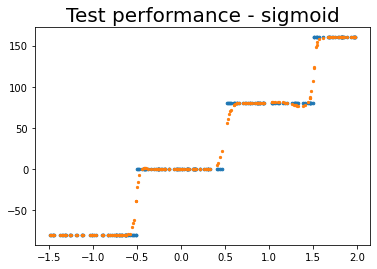

In [81]:
result = early_stop_network.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=7)
plt.scatter(x=x_test, y=np.concatenate(result), s=5)
plt.title('Test performance - sigmoid', fontsize=20)

Epoch: 0     Mean absolute error: 70.75621685980222
Epoch: 500   Mean absolute error: 12.805849079253269
Epoch: 1000  Mean absolute error: 7.179365816099365
Epoch: 1500  Mean absolute error: 9.24137096754043
Epoch: 2000  Mean absolute error: 9.355023165030527
Epoch: 2500  Mean absolute error: 8.771843341045422
Epoch: 3000  Mean absolute error: 8.647776021601517
Epoch: 3500  Mean absolute error: 8.542752667343754
Epoch: 4000  Mean absolute error: 8.487151976738847
Epoch: 4500  Mean absolute error: 4.336118824534287
Epoch: 5000  Mean absolute error: 8.389424169706146
Epoch: 5500  Mean absolute error: 8.457336020212631
Epoch: 6000  Mean absolute error: 4.062549232218878
Epoch: 6500  Mean absolute error: 2.7980021657634246
Epoch: 7000  Mean absolute error: 1.312803207549632
Epoch: 7500  Mean absolute error: 0.9679138044778162
Epoch: 8000  Mean absolute error: 0.7809685168005511
Epoch: 8500  Mean absolute error: 0.6616660494871687
Epoch: 9000  Mean absolute error: 0.5896525321155643
Epoch: 

Text(0.5, 1.0, 'Test performance - sigmoid')

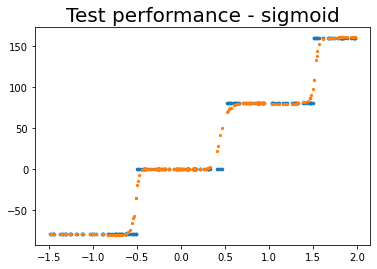

In [82]:
default_network = generate_random_mlp([1,10,30,10,1], activation_function="tanh", output_function='linear')
default_network.train(x_train, y_train, batch_size=128, epochs=10000, lr=0.001)

result = default_network.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=7)
plt.scatter(x=x_test, y=np.concatenate(result), s=5)
plt.title('Test performance - sigmoid', fontsize=20)

Epoch: 0     Mean absolute error: 69.66638781279364
Epoch: 500   Mean absolute error: 12.435710877321373
Epoch: 1000  Mean absolute error: 10.23650339151753
Epoch: 1500  Mean absolute error: 9.617625874415262
Epoch: 2000  Mean absolute error: 9.648285052882866
Epoch: 2500  Mean absolute error: 6.107904470160929
Epoch: 3000  Mean absolute error: 9.063973808305093
Epoch: 3500  Mean absolute error: 4.903443386696255
Epoch: 4000  Mean absolute error: 4.469747395154768
Epoch: 4500  Mean absolute error: 3.8983296698530565
Epoch: 5000  Mean absolute error: 3.406221842949216
Epoch: 5500  Mean absolute error: 3.0261598206400646
Epoch: 6000  Mean absolute error: 2.7977848120860354
Epoch: 6500  Mean absolute error: 2.6562219604168305
Epoch: 7000  Mean absolute error: 2.5486319944912355
Epoch: 7500  Mean absolute error: 2.4584623628283353
Epoch: 8000  Mean absolute error: 2.3857610225478614
Epoch: 8500  Mean absolute error: 2.3286072579380823
Epoch: 9000  Mean absolute error: 2.2841709630589184
Ep

Text(0.5, 1.0, 'Test performance - sigmoid')

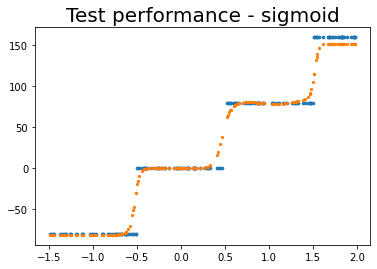

In [88]:
reg_network = generate_random_mlp([1,10,30,10,1], activation_function="tanh", output_function='linear')
reg_network.train(x_train, y_train, batch_size=128, epochs=10000, lr=0.001, regularization=0.01)

result = reg_network.forward_prop(x_test)

plt.scatter(x=x_test, y=y_test, s=7)
plt.scatter(x=x_test, y=np.concatenate(result), s=5)
plt.title('Test performance - sigmoid', fontsize=20)